# Ultimate Inc. : Data Analysis Challenge

## PART 1 - Exploratory Data Analysis 

### Objectives
1. Visualize & describe logins that best characterize the underlying pattern.
2. Illustrate and report important demand features, including daily cycles
3. Inspect data quality and report any anomalies.


In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import ks_2samp, kstest

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score, log_loss

from hyperopt import hp, fmin, tpe, Trials


In [191]:
login_df = pd.read_json("logins.json")
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


**Observations**
1. The json file has only 1 column with timestamps of login time. 
2. One notices that timestamps are **not necessarily in choronological order**, for e.g. timestamp at index 3 occurs before timestamp at index 2. 

Let's look at the data types and total amount of data.

In [113]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [114]:
login_df.isna().sum()

login_time    0
dtype: int64

Data is stored as a datatime object and there are no missing values. 
Next steps is to sort the data in chronological order.

In [192]:
login_df = login_df.sort_values(by='login_time', ascending=True).reset_index()
login_df = login_df.drop(columns=['index'])
login_df.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [116]:
login_df.tail()

,login_time
93137,1970-04-13 18:48:52
93138,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93140,1970-04-13 18:54:23
93141,1970-04-13 18:57:38


In [193]:
login_df.set_index('login_time', inplace=True)
login_df['count'] = 1
login_15min = login_df.resample('15min').sum()
login_15min = login_15min.rename(columns = {'count': 'no_of_logins'})
login_15min.head()

,no_of_logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [195]:
login_15min['hourly_logins'] = login_15min['no_of_logins'].rolling(window='H').sum()
login_15min['day'] = login_15min.index.day_name()
login_15min['hour'] = login_15min.index.hour
login_15min.head()


,no_of_logins,hourly_logins,day,hour
login_time,,,,
1970-01-01 20:00:00,2,2.0,Thursday,20
1970-01-01 20:15:00,6,8.0,Thursday,20
1970-01-01 20:30:00,9,17.0,Thursday,20
1970-01-01 20:45:00,7,24.0,Thursday,20
1970-01-01 21:00:00,1,23.0,Thursday,21


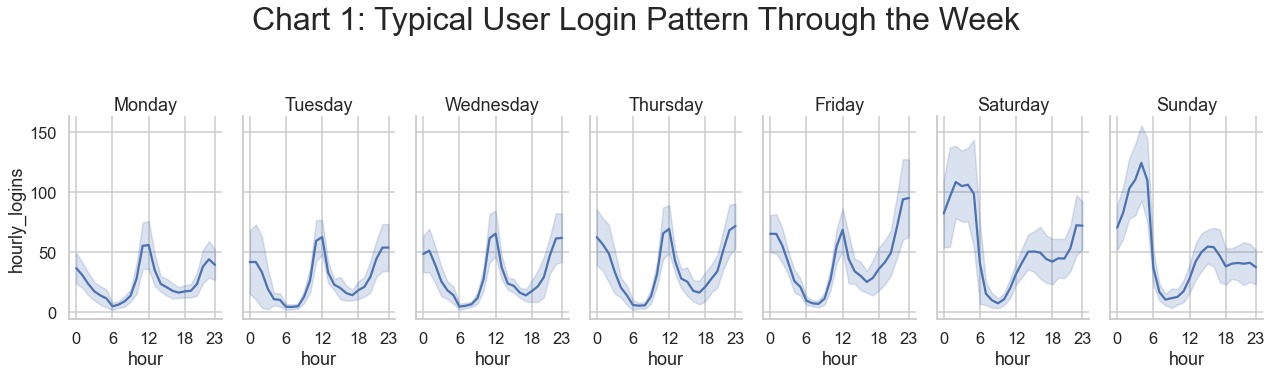

In [256]:
sns.set_style('whitegrid')
sns.set_context('talk')

g = sns.relplot(x='hour', y='hourly_logins', 
            data=login_15min, kind='line', 
            col='day', col_order = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
            col_wrap = 7,
               ci='sd')

g.fig.set_size_inches(18,5)
g.fig.suptitle('Chart 1: Typical User Login Pattern Through the Week', y=1.06, fontsize = 32)
g.set_titles("{col_name}")
value_tick = [0,6,12,18,23]
for ax in g.axes.flat:
    ax.set_xticks(ticks=value_tick)

plt.tight_layout()
plt.savefig("chart_1.png") 
plt.show()


## Login Pattern

The user logins have a **weekly pattern** as shown in Chart 1 above. The chart has been made based on pattern observed across approx. 14 full weeks of data. 

* The solid blue line indicates the mean (expected) logins per hr at a given time on a given day of the week, for e.g. around 12 noon on Monday, the expected logins are about 60 per hr.

* The light blue bands around the solid blue line show 1 standard deviation around the expected logins i.e. at 12 noon on Monday, 65% of the time the expected logins are between 35/hr to 75/hr.

AS one can see from the chart 1 above, Monday through Thursday the logins follow a similar pattern with a daily peak around noon. On weekends, the logins surge past midnight and peak at 4-5am the next day. More details on daily cycles in charts 2 and 3.

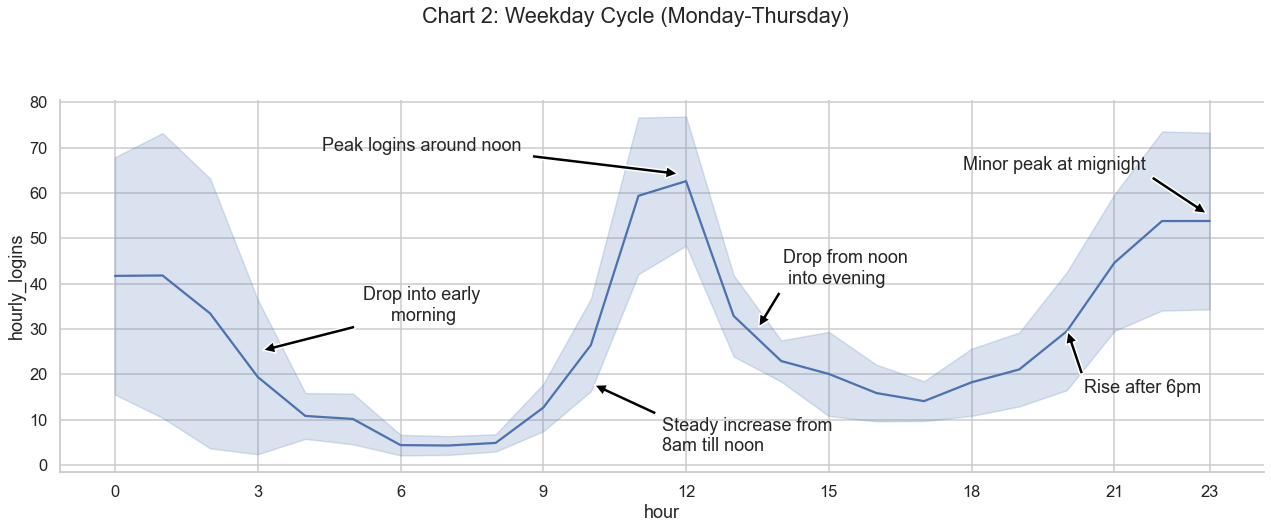

In [257]:
sns.set_style('whitegrid')
sns.set_context('talk')

g = sns.relplot(x='hour', y='hourly_logins', 
            data=login_15min[login_15min['day'] == 'Tuesday'], kind='line', 
               ci='sd')

g.fig.set_size_inches(18,7)
g.fig.suptitle('Chart 2: Weekday Cycle (Monday-Thursday)', y=1.06)
g.set_titles("{col_name}")
value_tick = [0,3,6,9,12,15,18,21,23]

plt.annotate('Peak logins around noon', xy=(12, 64),  xycoords='data', xytext=(0.3, 0.9), \
            textcoords='axes fraction', arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center', \
            verticalalignment='top')
plt.annotate('Drop into early\n morning', xy=(3, 25),  xycoords='data', xytext=(0.3, 0.5), \
            textcoords='axes fraction', arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center', \
            verticalalignment='top')
plt.annotate('Steady increase from \n8am till noon', xy=(10, 18),  xycoords='data', xytext=(0.5, 0.15), \
            textcoords='axes fraction', arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='left', \
            verticalalignment='top')
plt.annotate('Drop from noon\n into evening', xy=(13.5, 30),  xycoords='data', xytext=(0.6, 0.6), \
            textcoords='axes fraction', arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='left', \
            verticalalignment='top')

plt.annotate('Rise after 6pm', xy=(20, 30),  xycoords='data', xytext=(0.85, 0.25), \
            textcoords='axes fraction', arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='left', \
            verticalalignment='top')

plt.annotate('Minor peak at mignight', xy=(23, 55),  xycoords='data', xytext=(0.75, 0.85), \
            textcoords='axes fraction', arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='left', \
            verticalalignment='top')


for ax in g.axes.flat:
    ax.set_xticks(ticks=value_tick)

plt.tight_layout()
plt.savefig("chart_2.png") 
plt.show()


### Daily Cycles observed

**Weekdays (Monday - Thursday)**
The daily pattern for weekdays is repititive as shown on Chart 2. The solid blue line is the expected hourly logins and the light blue band indicates one standard deviation around the expected value.

1. There is a peak around midnight (40-60 logins per hour) followed by a drop into early morning (6am). 
2. The logins start rising after 8am and peak again at 60-80 logins/hr around noon.
3. Post noon, the logins gradually drop to below 20/hr by 5pm. 
4. The logins start climbing again after 6pm and peak around midnight.

The pattern for weekends (Friday to Sunday) is somewhat different than weekdays as shown on Chart 3 below. 

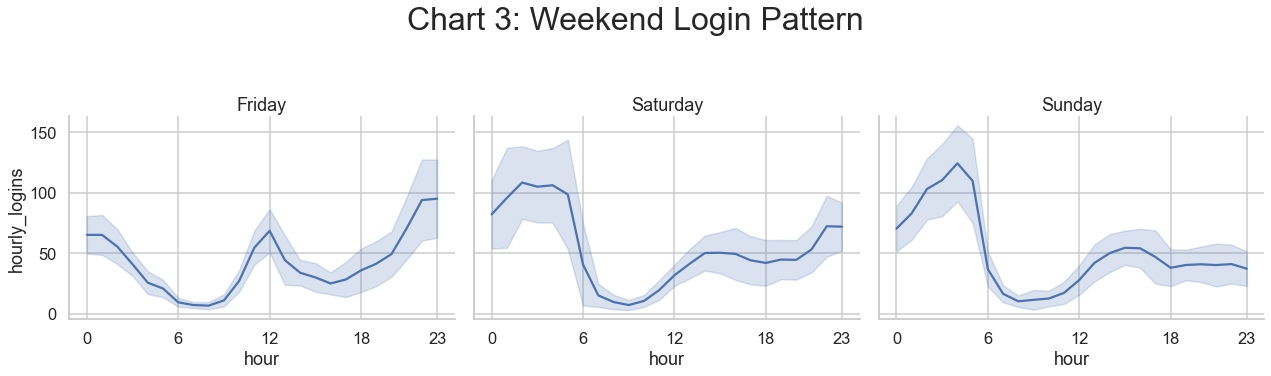

In [258]:

days = ['Friday','Saturday','Sunday']
df = login_15min[login_15min['day'].isin(days)]

sns.set_style('whitegrid')
sns.set_context('talk')


g = sns.relplot(x='hour', y='hourly_logins', 
            data=df, kind='line', 
            col='day', col_order = ['Friday','Saturday','Sunday'],
            col_wrap = 3,
               ci='sd')

g.fig.set_size_inches(18,5)
g.fig.suptitle('Chart 3: Weekend Login Pattern', y=1.06, fontsize = 32)
g.set_titles("{col_name}")
value_tick = [0,6,12,18,23]
for ax in g.axes.flat:
    ax.set_xticks(ticks=value_tick)

plt.tight_layout()
plt.savefig("chart_3.png") 
plt.show()


**Friday - Sunday**
1. Friday and Saturday nights see a surge in logins after 10pm that continues into early morning the next day. The hourly logins surge well past 100/hr after midnight and peak between 100-150/hr around 4-5am. 
2. Saturdays and Sundays see lower traffic during the day, with a minor peak around noon.
3. Sunday evenings see much lower traffic.

**Data Quality**
The data quality is fine. Data was available from 1st January, 1970 to 16th April, 1970. 

* There was 14 weeks (week 2 to 15) of complete data for all days of the week. 
* For week 1 and 16, partial data was available. This meant that for some days e.g. Monday 15 observations were available and for others e.g. Tuesday, 14 observations were available. However, given that a consistent pattern was found across weeks 2 to 15, this minor difference in no. of observations available does not impact the outcome of the analysis.


## PART 3 - Predictive Modeling 

### Objectives
1. Visualize & analyse data to understand what factors impact user retention. 
2. Create a predictive model for user retention.
3. Understand key features that affect user retention and advise Ultimate on how it could leverage these insights.


In [101]:
user_data = pd.read_json("ultimate_data_challenge.json")
user_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
user_data.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [33]:
user_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


We find above that the data needs some cleaning up:
1. The sign_up and last_trip dates are stored as strings, so need to be converted to datatime
2. 3 features have missing values, with avg_rating_of_driver having a lot of them (16%).


In [102]:
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [8]:
print(f"Sign-up dates: \nEarliest: {user_data['signup_date'].min()}\nLatest: {user_data['signup_date'].max()}")

Sign-up dates: 
Earliest: 2014-01-01 00:00:00
Latest: 2014-01-31 00:00:00


In [321]:
print(f"Last trip date: \nEarliest: {user_data['last_trip_date'].min()}\nLatest: {user_data['last_trip_date'].max()}")

Last trip date: 
Earliest: 2014-01-01 00:00:00
Latest: 2014-07-01 00:00:00


In [103]:
cut_off_date = datetime.strptime("2014-06-01", "%Y-%m-%d")
user_data['status'] = user_data['last_trip_date'].map(lambda x: "active" if (x >= cut_off_date) else "inactive")
user_data['status'].value_counts()

inactive    31196
active      18804
Name: status, dtype: int64

In [104]:
user_data['missing_driver_rating'] = user_data['avg_rating_of_driver'].isna()
pd.crosstab(user_data['status'], user_data['missing_driver_rating'])

missing_driver_rating,False,True
status,,
active,17172,1632
inactive,24706,6490


In [57]:
user_data[~user_data['missing_driver_rating']].groupby('status')['avg_rating_of_driver'].mean()

status
active      4.592930
inactive    4.607557
Name: avg_rating_of_driver, dtype: float64

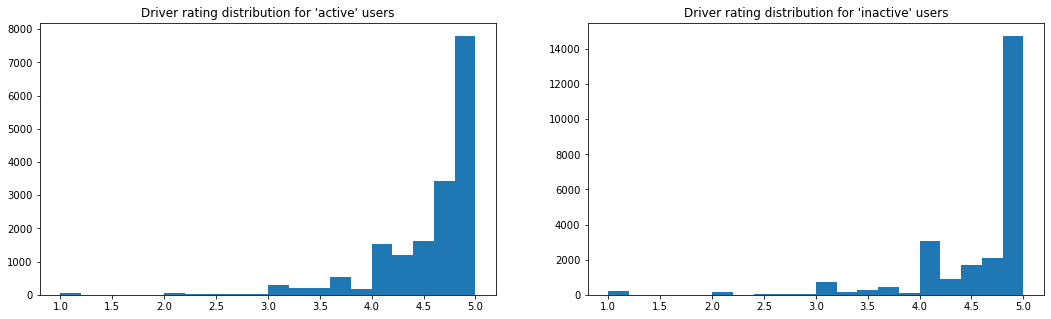

In [58]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
for i, status in enumerate(list(user_data['status'].unique())):
    axes = ax.flatten()[i]
    axes.hist(user_data[user_data['status'] == status]['avg_rating_of_driver'], bins=20)
    axes.set_title(f"Driver rating distribution for '{status}' users")
    
plt.show()

In [59]:
ks_2samp(user_data[user_data['status'] == "active"]['avg_rating_of_driver'], 
         user_data[user_data['status'] == "inactive"]['avg_rating_of_driver'])

KstestResult(statistic=0.23909253415811904, pvalue=0.0)

**Key Observations**:

1) 80% of users (6490 out of 8122)) with missing driver ratings do not stay with the service.
2) The average driver ratings given by active and inactive users are very similar (4.59 vs 4.61). The distribution of ratings are not similar though, as evidenced by 0.0 p-value of the KS test. 

This suggests that missing 'driver ratings' could themselves be a strong predictor of whether a user will stay or drop out. 
We should keep the observations with missing 'driver ratings'. Now we need to determine how to impute the missing driver ratings. An option is to impute it with the mean of all available ratings. In doing so, we need to be sure that it won't change the original fact that the distributions are dissimilar. 


In [141]:
user_data['avg_rating_of_driver'].fillna(user_data['avg_rating_of_driver'].mean(), inplace=True)
user_data.groupby('status')['avg_rating_of_driver'].mean()

status
active      4.593679
inactive    4.606309
Name: avg_rating_of_driver, dtype: float64

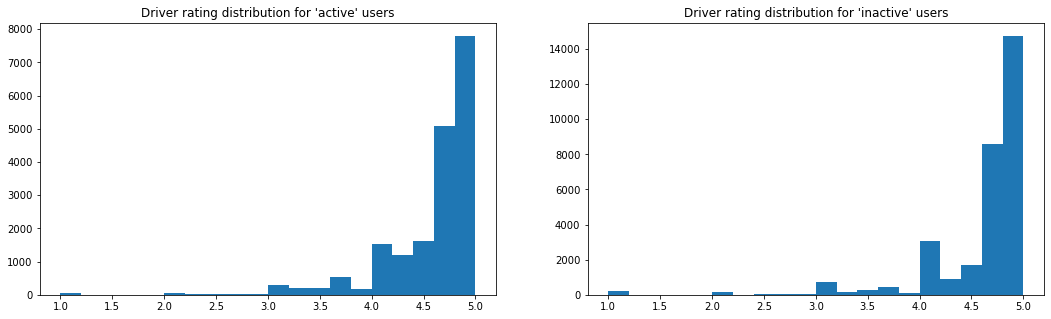

In [62]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
for i, status in enumerate(list(user_data['status'].unique())):
    axes = ax.flatten()[i]
    axes.hist(user_data[user_data['status'] == status]['avg_rating_of_driver'], bins=20)
    axes.set_title(f"Driver rating distribution for '{status}' users")
    
plt.show()

In [63]:
ks_2samp(user_data[user_data['status'] == "active"]['avg_rating_of_driver'], 
         user_data[user_data['status'] == "inactive"]['avg_rating_of_driver'])

KstestResult(statistic=0.11784308658687037, pvalue=2.0752103690805287e-142)

The missing driver ratings were imputed with mean value. That has not changed the mean and the distributions of active vs inactive users are still dissimilar, based on the KS-test. 


In [64]:
user_data['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [65]:
user_data['avg_rating_by_driver'].mean()

4.778158195947439

The **'phone'** and **'avg_rating_by_driver'** are missing for less than 1% of the customers. Let's impute 'phone' with the most-frequent value ('iPhone') and 'avg_rating_by_driver' with the mean value (4.778)

In [105]:
user_data['phone'].fillna(user_data['phone'].mode()[0], inplace=True)
user_data['avg_rating_by_driver'].fillna(user_data['avg_rating_by_driver'].mean(), inplace=True)


In [106]:
user_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,status,missing_driver_rating
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,active,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,inactive,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,inactive,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,active,False
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,inactive,False


In [68]:
active_by_city = pd.DataFrame(pd.crosstab(user_data['city'], user_data['status']))
active_by_city['Total'] = active_by_city.sum(axis=1)
active_by_city['percent_active'] = np.round(active_by_city['active'] * 100.0/ active_by_city['Total'],2)
active_by_city

status,active,inactive,Total,percent_active
city,,,,
Astapor,4228,12306,16534,25.57
King's Landing,6363,3767,10130,62.81
Winterfell,8213,15123,23336,35.19


In [69]:
active_by_phone = pd.DataFrame(pd.crosstab(user_data['phone'], user_data['status']))
active_by_phone['Total'] = active_by_phone.sum(axis=1)
active_by_phone['percent_active'] = np.round(active_by_phone['active'] * 100.0/ active_by_phone['Total'],2)
active_by_phone

status,active,inactive,Total,percent_active
phone,,,,
Android,3146,11876,15022,20.94
iPhone,15658,19320,34978,44.77


In [70]:
active_by_blackuser = pd.DataFrame(pd.crosstab(user_data['ultimate_black_user'], user_data['status']))
active_by_blackuser = active_by_blackuser.rename(index = {False: 'Not used ultimate-black', True : 'Used ultimate-black'})
active_by_blackuser['Total'] = active_by_blackuser.sum(axis=1)
active_by_blackuser['percent_active'] = np.round(active_by_blackuser['active'] * 100.0/ active_by_blackuser['Total'],2)
active_by_blackuser

status,active,inactive,Total,percent_active
ultimate_black_user,,,,
Not used ultimate-black,9307,21839,31146,29.88
Used ultimate-black,9497,9357,18854,50.37


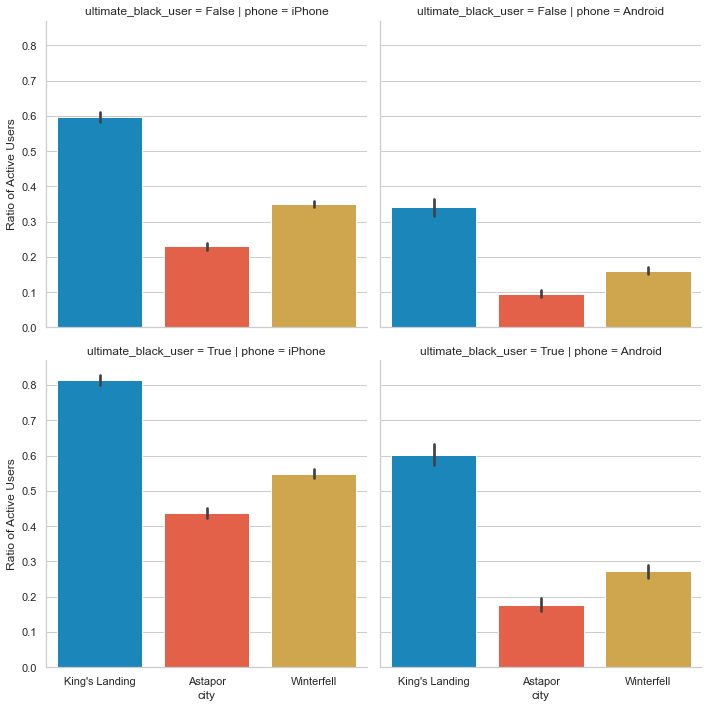

In [361]:
user_data['active'] = user_data['status'] == 'active'
sns.set_style('whitegrid')
sns.set_context('notebook')
g = sns.catplot(x='city', y='active', data = user_data, col = 'phone', row = 'ultimate_black_user', kind='bar')
g.set(ylabel = 'Ratio of Active Users')
plt.show()
g.fig.savefig('charts/city_phone_black.jpg')


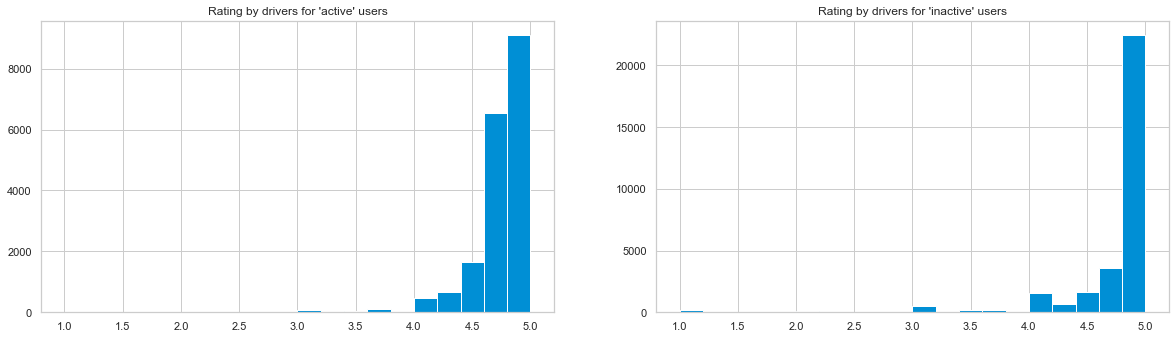

In [362]:
sns.set_style('whitegrid')
sns.set_context('notebook')
fig, ax = plt.subplots(1,2, figsize=(18,5))
for i, status in enumerate(list(user_data['status'].unique())):
    axes = ax.flatten()[i]
    axes.hist(user_data[user_data['status'] == status]['avg_rating_by_driver'], bins=20)
    axes.set_title(f"Rating by drivers for '{status}' users")
    
plt.show()
fig.savefig("charts/ratings_by_drivers.jpg")

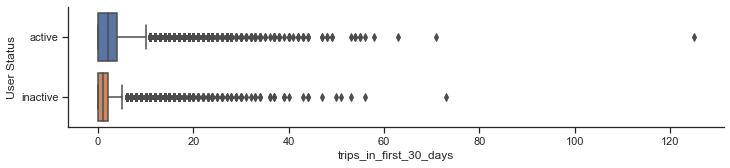

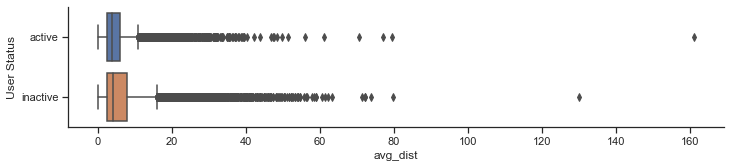

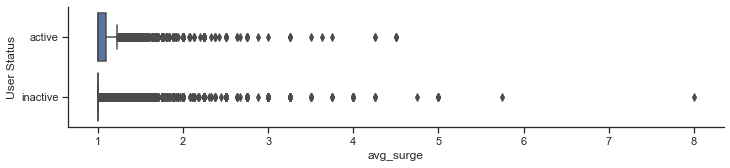

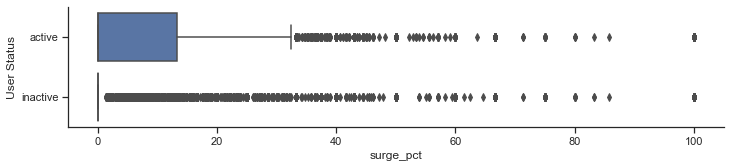

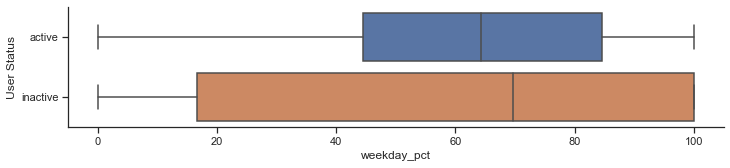

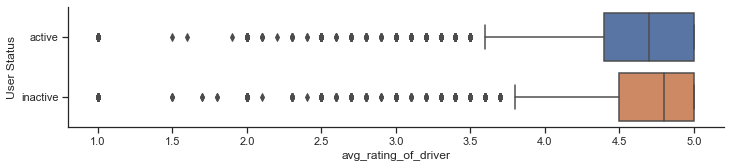

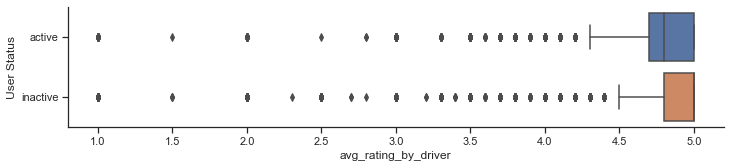

In [87]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_theme(style="ticks")
features = ['trips_in_first_30_days', 'avg_dist', 'avg_surge', 'surge_pct','weekday_pct', \
                            'avg_rating_of_driver', 'avg_rating_by_driver']
for feature in features:
    g = sns.catplot(y='status', x=feature,  data = user_data, kind='box')
    g.fig.set_size_inches(12,2)
    g.set(ylabel="User Status")
plt.show()

In [88]:
user_data.groupby("status")[['trips_in_first_30_days', 'avg_dist', 'avg_surge', 'surge_pct','weekday_pct', \
                            'avg_rating_of_driver', 'avg_rating_by_driver']].mean()

,trips_in_first_30_days,avg_dist,avg_surge,surge_pct,weekday_pct,avg_rating_of_driver,avg_rating_by_driver
status,,,,,,,
active,3.306318,5.114788,1.073809,9.152797,61.389034,4.593679,4.762801
inactive,1.658482,6.207939,1.075339,8.666739,60.647032,4.606309,4.787415


In [108]:
# Let's check if signup's on certain day of the week have higher chance of retention

user_data['signup_day'] = user_data['signup_date'].dt.day_name()
active_by_day = pd.DataFrame(pd.crosstab(user_data['signup_day'], user_data['status']))
active_by_day['Total'] = active_by_day.sum(axis=1)
active_by_day['percent_active'] = np.round(active_by_day['active'] * 100.0/ active_by_day['Total'],2)
active_by_day


status,active,inactive,Total,percent_active
signup_day,,,,
Friday,3619,6148,9767,37.05
Monday,2073,3270,5343,38.80
Saturday,3698,6022,9720,38.05
Sunday,2467,3946,6413,38.47
Thursday,2501,4444,6945,36.01
Tuesday,1927,3197,5124,37.61
Wednesday,2519,4169,6688,37.66


From the above table, we see that the day of signup has very little impact on retention chances, with most days in the 36-39% range. 

### Key Learnings from EDA
Out of 50,000 users who signed up in Jan-2014, 18804 i.e 37.6% were still active after 6 months. 

Some of the key factors that impact user retention are:
1) **City**: Out of the 3 cities, King's Landing users have the highest retention rate of 63%, followed by Winterfell (35%) and Astapor(26%). 

2) **Phone**: An iPhone user is twice more likely to stay (45%) as compared to an Android user (21%).

3) **Ultimate-black**: A user of ultimate black has a much higher chance of staying at 50%, while those who haven't used ultimate black only have a 30% chance of staying.

4) **City-phone-ultimate_black**: Combining the above 3 categorical factors, we find some very interesting facts:
    
* An iPhone user from King's Landing who has used ultimate_black has an **81%** chance of staying
    
* An Android user from Astapor who hasn't used ultimate_black has only a **10%** chance of staying
    
* An Android user from Winterfell who hasn't used ultimate_black has only a **15%** chance of staying
    
5) **Trips in first 30 days**: This is a good indicator of retention. Users who drop off from the service, usually take less than 2 trips on average in the first 30 days, while those who continue take more than 3 trips on average in the first 30 days.

6) **Driver Ratings**: There is an 80% chance that users who have not provided any driver ratings would drop-off from the service.

With many of the other factors like sign_up day, avg_dist, surge_pct, weekday_pct, driver ratings, the active and inactive users show similar behavior and it is harder to distingush whether the user would stay or not.


### Predicting Rider Retention

Our dataset has a mix of numeric and categorical features, while the target "retention" is a binary categorical variable. So it is a binary classification problem.  
To build a predictive model, the intuition is to build models based on Logistic Regression or decision tree based classifiers such as Random Forest as well as gradient boosted decision tree algorithms such as XGBoost or Light GBM.

But before we get into building a model, shall pre-process the dataset.


### Pre-processing the dataset
In the pre-processing, we carry out the following steps:

1) Remove undesired columns e.g. signup_day that we added during EDA, but don't require any more.
2) Standardize the numeric columns
3) One-hot encode the categorical columns
4) Split the dataset into training and test sets.


In [125]:
user_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,status,missing_driver_rating,active,signup_day
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,active,False,True,Saturday
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,inactive,False,False,Wednesday
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,inactive,False,False,Monday
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,active,False,True,Friday
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,inactive,False,False,Monday


In [213]:

X = user_data.drop(columns = ['signup_date', 'last_trip_date', 'status', 'signup_day', 'active'])
y = user_data['active']
X.shape, y.shape

((50000, 11), (50000,))

In [204]:
X.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,missing_driver_rating
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,False
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,False
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,False


In [145]:
num_features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct',
                       'weekday_pct', 'avg_dist', 'avg_rating_by_driver']

for feature in num_features:
    ks_statistic, p_value = kstest(user_data[feature], 'norm')
    print(f'feature: {feature} --> p-value of KS test = {p_value:4.4f}')
    

feature: trips_in_first_30_days --> p-value of KS test = 0.0000
feature: avg_rating_of_driver --> p-value of KS test = 0.0000
feature: avg_surge --> p-value of KS test = 0.0000
feature: surge_pct --> p-value of KS test = 0.0000
feature: weekday_pct --> p-value of KS test = 0.0000
feature: avg_dist --> p-value of KS test = 0.0000
feature: avg_rating_by_driver --> p-value of KS test = 0.0000


All numeric features are not normally distributed. Moreover, we saw there were a lot of outlier in these features.
So let's use Robust Scaler to scale the numeric data.

In [214]:
num_features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct',
                       'weekday_pct', 'avg_dist', 'avg_rating_by_driver']

scaler = RobustScaler()
#scaler = StandardScaler()

X[num_features] = scaler.fit_transform(X[num_features])



In [216]:
# Next we one-hot encode the categorical features

X = pd.get_dummies(X, drop_first=True)


In [217]:
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,missing_driver_rating,city_King's Landing,city_Winterfell,phone_iPhone
0,1.000000,0.0,2.0,1.790698,True,-0.307346,-0.046460,0.000000,False,1,0,1
1,-0.333333,0.6,0.0,0.000000,False,-0.250375,0.969027,0.000000,False,0,0,0
2,0.666667,-0.8,0.0,0.000000,False,0.499250,-0.688053,0.000000,False,0,0,1
3,2.666667,-0.2,2.8,2.325581,True,0.199400,-0.336283,-0.333333,False,1,0,1
4,4.333333,-0.6,3.8,1.372093,False,0.235382,-0.165929,-0.333333,False,0,1,0


In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 12), (10000, 12), (40000,), (10000,))

In [322]:
type(X_train),type(y_train) 

(pandas.core.frame.DataFrame, pandas.core.series.Series)

## Modelling

The task is to predict whether a user will be active or not by their 6th month. So this is a classification task with a binary target variable. The intuition is to build models based on classifiers such as Logistic Regression, Decision Trees and Gradient Boosted decision trees. 
While a key metric is recall for the users that remain active, recall alone shouldn't be the only criteria. We do want to understand users that will not remain active and therefore we should not try to maximise recall at the expense of lowering precision or overall accuracy. As such, balanced metrics like 'overall accuracy' or 'AUC' would be the right metrics to evaluate the performance of the models.

Let's begin by defining some function to build, tune and evaluate 3 different classifiers:

1) Random Forest

2) Logistic Regression

3) XG Boost


### Functions

In [352]:

def plot_feature_importance(model, model_name):
        # Function to plot relative feature importance
        
        feature_importance = model.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        print(pos.size)
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(5,5))
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title(f'{model_name} Model\nFeature Importances')
        plt.show()

def rf_predict_plot(n_estimators = 300, max_depth = 5, min_samples_split = 2,
                    min_samples_leaf = 1, max_features = 1.0, max_samples = 1.0, plot = False):
    
    # Function for building a RF classifer and generating various evaluation metrics
    
    global rf_clf 
    
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth = max_depth, 
                                    min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                    max_features = max_features, max_samples = max_samples,
                                    random_state = 123,n_jobs=-1)

    model_res = rf_clf.fit(X_train.to_numpy(), y_train.astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    rf_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test.astype('int'), y_pred)

    f1 = f1_score(y_test.astype('int'), y_pred, average='weighted')
    
    cm = np.around(confusion_matrix(y_test.astype('int'), y_pred, normalize = 'true'), 4)
    cm1= confusion_matrix(y_test.astype('int'), y_pred)

    print(f"Random Forest Classifier results ")
    print(f"Parameters:\nNo. of Estimators = {n_estimators}\nmax_depth = {max_depth}")
    print(f"min_samples_split = {min_samples_split}\nmin_samples_leaf = {min_samples_leaf}")
    print(f"max_features = {max_features}\nmax_samples = {max_samples}")
    print(f'\nAccuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)
    
        cr = classification_report(y_test.astype('int'), y_pred)
        print("\nClassification Report \n", cr)
    
        plot_feature_importance(rf_clf, "Random Forest")
        
    return ac, f1, rf_probs, y_pred

def xg_predict_plot(n_estimators=300, max_depth = 3, gamma = 0, min_child_weight=1,
                    learning_rate = 0.3, colsample_bytree = 0.5, reg_lambda = 1,
                    plot = False):

    # Function for building a XG Boost classifer and generating various evaluation metrics

    global xg_clf  
    
    xg_clf = xgb.XGBClassifier(max_depth=max_depth, objective='binary:logistic', n_estimators=n_estimators, \
                               learning_rate = learning_rate, colsample_bytree = colsample_bytree, gamma = gamma, 
                               reg_lambda = reg_lambda, min_child_weight = min_child_weight,
                               n_jobs=-1, random_state=1)

    model_res = xg_clf.fit(X_train.to_numpy(), y_train.astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test.astype('int'), y_pred)

    f1 = f1_score(y_test.astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test.astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test.astype('int'), y_pred)

    print(f"XGBoost Classifier results")
    print(f"Parameters:\nNo. of Estimators = {n_estimators}\nmax_depth = {max_depth}")
    print(f"learning_rate = {learning_rate}\ncolsample_bytree = {colsample_bytree}")
    print(f"min_child_weight = {min_child_weight}\ngamma = {gamma}")
    print(f"reg_lambda = {reg_lambda}")
    print(f'Accuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)

        cr = classification_report(y_test.astype('int'), y_pred)
        print("\nClassification Report \n", cr)
        
        plot_feature_importance(xg_clf, "XG Boost")
        
    return ac, f1, xg_probs, y_pred

def lr_predict():
    # Function for building a Logistic Regression classifer and generating various evaluation metrics
    
    logreg = LogisticRegression()
    logreg.fit(X_train.to_numpy(), y_train.astype('int'))
    y_pred = logreg.predict(X_test.to_numpy())
    y_pred_prob = logreg.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test.astype('int'), y_pred)

    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test.astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test.astype('int'), y_pred)

    print(f'Logistic Regression')
    print(f'Accuracy = {ac:4.4}, f1-score = {f1:4.4}\n')
    print("Confusion Matrix - normalized\n", cm)
    print("Confusion Matrix\n", cm1)

    cr = classification_report(y_test.astype('int'), y_pred)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test.astype('int'), lr_probs)
    roc_auc2 = auc(fpr_2, tpr_2)
    print("\nClassification Report \n", cr)
    print("\nArea under ROC: \n", roc_auc2)
    
    return ac, f1, lr_probs, y_pred

def xgb_hyperopt(space):
    
    # objective function that returns loss function for a set of hyperparamters to hyperopt 
    # used iteratively for tuning XG Boost hyperparameters

    clf=xgb.XGBClassifier(objective='binary:logistic',
                    n_estimators = int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_lambda = space['reg_lambda'],
                    min_child_weight = int(space['min_child_weight']),
                    colsample_bytree = space['colsample_bytree'],
                    learning_rate = space['learning_rate'],
                    eval_metric = 'error',
                    n_jobs=-1, random_state=1)
    
    evaluation = [( X_train.to_numpy(), y_train.astype('int')), (X_test.to_numpy(), y_test.astype('int'))]
    
    clf.fit(X_train.to_numpy(), y_train.astype('int'), verbose=True)
    
    pred = clf.predict(X_test.to_numpy())
    accuracy = accuracy_score(y_test.astype('int'), pred)
    print(f"SCORE: {round(accuracy,4)}, trees: {int(space['n_estimators'])}, depth: {int(space['max_depth'])}, gamma: {round(space['gamma'],3)}, lambda: {round(space['reg_lambda'],3)}, min_kid_weight: = {int(space['min_child_weight'])}, colsamp_bytree: {round(space['colsample_bytree'],3)}, lr: {round(space['learning_rate'],3)}")
    
    return -accuracy 

def rf_hyperopt(space):
    # objective function that returns loss function for a set of hyperparamters to hyperopt 
    # used iteratively for tuning Random Forest hyperparameters
    
    clf = RandomForestClassifier(n_estimators = int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    min_samples_split = int(space['min_samples_split']),
                    min_samples_leaf = int(space['min_samples_leaf']),
                    max_features = space['max_features'],
                    max_samples = space['max_samples'],
                    n_jobs=-1, random_state=123)
    
    clf.fit(X_train.to_numpy(), y_train.astype('int'))
    
    pred = clf.predict(X_test.to_numpy())
    accuracy = accuracy_score(y_test.astype('int'), pred)
    print(f"SCORE: {round(accuracy,4)}, trees: {int(space['n_estimators'])}, depth: {int(space['max_depth'])}, samp_split: {int(space['min_samples_split'])}, samp_leaf: {int(space['min_samples_leaf'])}, features: = {round(space['max_features'],3)}, max_samp: {round(space['max_samples'],3)}")
    
    return -accuracy 



### Random Forest Model

In [329]:
# Tuning Hyperparameters

trials = Trials()

space = {'n_estimators': hp.quniform('n_estimators', 250, 500, 50),
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'min_samples_split': hp.quniform("min_samples_split", 2, 10, 1),
        'min_samples_leaf': hp.quniform("min_samples_leaf", 1, 5, 1),
        'max_features' : hp.uniform('max_features', 0.5,1),
        'max_samples' : hp.uniform('max_samples', 0.25,1)
      }

best_hyperparams = fmin(fn = rf_hyperopt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials
                       )

SCORE: 0.7777, trees: 250, depth: 7, samp_split: 8, samp_leaf: 4, features: = 0.649, max_samp: 0.993                   
SCORE: 0.7489, trees: 300, depth: 4, samp_split: 6, samp_leaf: 2, features: = 0.91, max_samp: 0.529                    
SCORE: 0.7829, trees: 350, depth: 10, samp_split: 9, samp_leaf: 3, features: = 0.789, max_samp: 0.981                  
SCORE: 0.7725, trees: 350, depth: 5, samp_split: 3, samp_leaf: 5, features: = 0.638, max_samp: 0.58                    
SCORE: 0.7801, trees: 300, depth: 9, samp_split: 4, samp_leaf: 2, features: = 0.935, max_samp: 0.834                   
SCORE: 0.7801, trees: 250, depth: 8, samp_split: 4, samp_leaf: 4, features: = 0.689, max_samp: 0.917                   
SCORE: 0.7718, trees: 400, depth: 5, samp_split: 9, samp_leaf: 4, features: = 0.503, max_samp: 0.697                   
SCORE: 0.7737, trees: 400, depth: 7, samp_split: 6, samp_leaf: 2, features: = 0.927, max_samp: 0.636                   
SCORE: 0.7809, trees: 350, depth: 9, sam

SCORE: 0.7844, trees: 500, depth: 10, samp_split: 7, samp_leaf: 4, features: = 0.737, max_samp: 0.258                  
SCORE: 0.7824, trees: 500, depth: 9, samp_split: 7, samp_leaf: 5, features: = 0.643, max_samp: 0.252                   
SCORE: 0.7831, trees: 500, depth: 10, samp_split: 7, samp_leaf: 4, features: = 0.738, max_samp: 0.369                  
SCORE: 0.781, trees: 500, depth: 9, samp_split: 6, samp_leaf: 4, features: = 0.712, max_samp: 0.524                    
SCORE: 0.7821, trees: 500, depth: 10, samp_split: 7, samp_leaf: 5, features: = 0.69, max_samp: 0.391                   
SCORE: 0.782, trees: 350, depth: 10, samp_split: 9, samp_leaf: 3, features: = 0.889, max_samp: 0.251                   
SCORE: 0.7806, trees: 400, depth: 8, samp_split: 8, samp_leaf: 4, features: = 0.672, max_samp: 0.423                   
SCORE: 0.7824, trees: 500, depth: 9, samp_split: 7, samp_leaf: 5, features: = 0.823, max_samp: 0.306                   
SCORE: 0.7828, trees: 300, depth: 10, sa

In [331]:
best_hyperparams # random forest - 0.7844

{'max_depth': 10.0,
 'max_features': 0.73739790375951,
 'max_samples': 0.25793922838801747,
 'min_samples_leaf': 4.0,
 'min_samples_split': 7.0,
 'n_estimators': 500.0}

Random Forest Classifier results 
Parameters:
No. of Estimators = 500
max_depth = 10
min_samples_split = 7
min_samples_leaf = 4
max_features = 0.7374
max_samples = 0.2579

Accuracy=0.7836, f1-score=0.7805
Confusion Matrix - normalized
 [[0.863  0.137 ]
 [0.3469 0.6531]]
Confusion Matrix
 [[5366  852]
 [1312 2470]]

Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83      6218
           1       0.74      0.65      0.70      3782

    accuracy                           0.78     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.78      0.78      0.78     10000

12


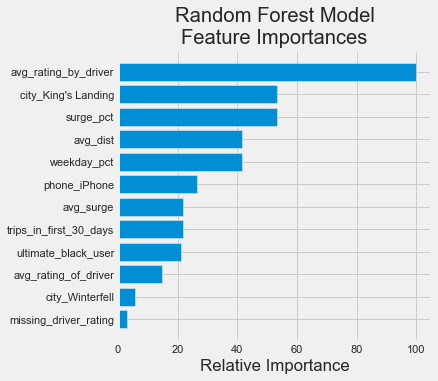

In [344]:
# Making predictions with best hyperparamters on test set and generating model evaluation metrics

rf_ac, rf_f1, rf_probs, rf_preds = rf_predict_plot(n_estimators = 500, max_depth = 10, min_samples_split = 7,
                                                    min_samples_leaf = 4, max_features = 0.7374, max_samples = 0.2579,
                                                    plot=True)

### XG Boost Model

In [307]:
# Tuning Hyperparameters

trials = Trials()

space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_lambda' : hp.uniform('reg_lambda', 0.5,2),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 8, 1),
        'n_estimators': hp.quniform('n_estimators', 250, 500, 50),
        'learning_rate': hp.uniform('learning_rate', 0.1, 0.35)
    }

best_hyperparams = fmin(fn = xgb_hyperopt,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                       verbose = True)


SCORE: 0.7904, trees: 250, depth: 6, gamma: 4.673, lambda: 1.339, min_kid_weight: = 2, colsamp_bytree: 0.702, lr: 0.218
SCORE: 0.7873, trees: 350, depth: 4, gamma: 4.06, lambda: 0.931, min_kid_weight: = 6, colsamp_bytree: 0.866, lr: 0.101 
SCORE: 0.7913, trees: 450, depth: 8, gamma: 1.406, lambda: 1.393, min_kid_weight: = 4, colsamp_bytree: 0.862, lr: 0.129
SCORE: 0.7876, trees: 450, depth: 4, gamma: 2.276, lambda: 1.15, min_kid_weight: = 1, colsamp_bytree: 0.98, lr: 0.249  
SCORE: 0.7863, trees: 300, depth: 6, gamma: 2.043, lambda: 1.284, min_kid_weight: = 7, colsamp_bytree: 0.823, lr: 0.274
SCORE: 0.7892, trees: 350, depth: 6, gamma: 3.733, lambda: 1.486, min_kid_weight: = 6, colsamp_bytree: 0.642, lr: 0.136
SCORE: 0.7905, trees: 350, depth: 6, gamma: 3.618, lambda: 1.603, min_kid_weight: = 2, colsamp_bytree: 0.642, lr: 0.168
SCORE: 0.7847, trees: 350, depth: 6, gamma: 0.75, lambda: 1.446, min_kid_weight: = 4, colsamp_bytree: 0.869, lr: 0.319 
SCORE: 0.7892, trees: 400, depth: 6, gam

SCORE: 0.7902, trees: 400, depth: 4, gamma: 3.759, lambda: 0.562, min_kid_weight: = 1, colsamp_bytree: 0.572, lr: 0.296
SCORE: 0.7881, trees: 350, depth: 5, gamma: 4.684, lambda: 0.702, min_kid_weight: = 2, colsamp_bytree: 0.533, lr: 0.229
SCORE: 0.7902, trees: 400, depth: 4, gamma: 3.002, lambda: 0.971, min_kid_weight: = 0, colsamp_bytree: 0.602, lr: 0.274
SCORE: 0.7924, trees: 250, depth: 5, gamma: 4.32, lambda: 1.114, min_kid_weight: = 3, colsamp_bytree: 0.65, lr: 0.31   
SCORE: 0.7892, trees: 300, depth: 4, gamma: 2.562, lambda: 0.829, min_kid_weight: = 0, colsamp_bytree: 0.684, lr: 0.243
SCORE: 0.7903, trees: 350, depth: 6, gamma: 3.656, lambda: 0.501, min_kid_weight: = 1, colsamp_bytree: 0.521, lr: 0.214
SCORE: 0.7933, trees: 400, depth: 5, gamma: 3.504, lambda: 0.6, min_kid_weight: = 4, colsamp_bytree: 0.555, lr: 0.259  
SCORE: 0.7914, trees: 400, depth: 5, gamma: 3.398, lambda: 1.055, min_kid_weight: = 4, colsamp_bytree: 0.548, lr: 0.257
SCORE: 0.7917, trees: 400, depth: 6, gam

XGBoost Classifier results
Parameters:
No. of Estimators = 400
max_depth = 8
learning_rate = 0.1097
colsample_bytree = 0.5119
min_child_weight = 6
gamma = 3.058
reg_lambda = 0.7287
Accuracy=0.7936, f1-score=0.791
Confusion Matrix - normalized
 [[0.8672 0.1328]
 [0.3273 0.6727]]
Confusion Matrix
 [[5392  826]
 [1238 2544]]

Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      6218
           1       0.75      0.67      0.71      3782

    accuracy                           0.79     10000
   macro avg       0.78      0.77      0.78     10000
weighted avg       0.79      0.79      0.79     10000

12


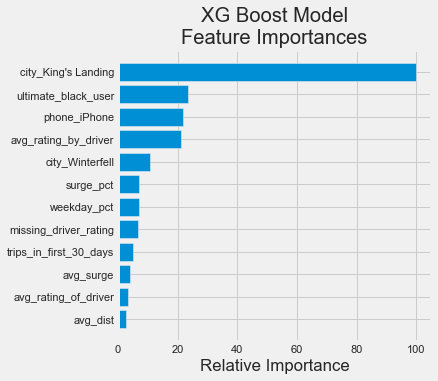

In [347]:
# Making predictions with best hyperparamters on test set and generating model evaluation metrics

xg_ac, xg_f1, xg_probs, xg_preds = xg_predict_plot(n_estimators=400, max_depth = 8, gamma = 3.058, min_child_weight=6,
                                                   learning_rate = 0.1097, colsample_bytree = 0.5119, reg_lambda = 0.7287,
                                                   plot = True)

### Logistic Regression Model

In [222]:
# Making predictions on test set and generating model evaluation metrics
lr_ac, lr_f1, lr_probs, lr_preds = lr_predict()


Logistic Regression
Accuracy = 0.7205, f1-score = 0.7098

Confusion Matrix - normalized
 [[0.8548 0.1452]
 [0.5003 0.4997]]
Confusion Matrix
 [[5315  903]
 [1892 1890]]

Classification Report 
               precision    recall  f1-score   support

           0       0.74      0.85      0.79      6218
           1       0.68      0.50      0.57      3782

    accuracy                           0.72     10000
   macro avg       0.71      0.68      0.68     10000
weighted avg       0.71      0.72      0.71     10000


Area under ROC: 
 0.7652588338490852


### Evaluating and comparing the 3 Models

In [348]:

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test.astype('int'), rf_probs)
roc_auc_rf = auc(fpr_1, tpr_1)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test.astype('int'), xg_probs)
roc_auc_xg = auc(fpr_2, tpr_2)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test.astype('int'), lr_probs)
roc_auc_lr = auc(fpr_3, tpr_3)

print(f"AUC score for Random Forest Model: {roc_auc_rf: 5.4f}")
print(f"AUC score for XG Boost Model: {roc_auc_xg: 5.4f}")
print(f"AUC score for Logistic Regression Model: {roc_auc_lr: 5.4f}")


AUC score for Random Forest Model:  0.8503
AUC score for XG Boost Model:  0.8602
AUC score for Logistic Regression Model:  0.7653


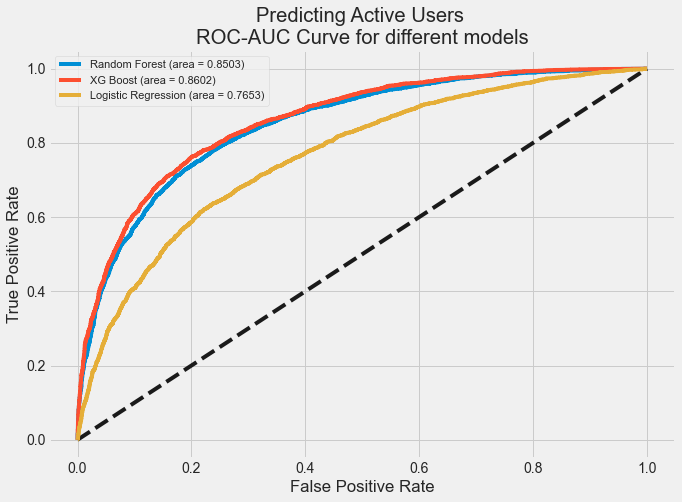

In [377]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1, figsize=(10,7))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.8503)')
plt.plot(fpr_2, tpr_2, label='XG Boost (area = 0.8602)')
plt.plot(fpr_3, tpr_3, label='Logistic Regression (area = 0.7653)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting Active Users \nROC-AUC Curve for different models')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()
fig.savefig("charts/roc_auc_curve.jpg")

Logistic Regression Model
Best Accuracy score of 0.723 occurs for threshold = 0.479
Random Forest Model
Best Accuracy score of 0.7846 occurs for threshold = 0.493
XG Boost Model
Best Accuracy score of 0.7942 occurs for threshold = 0.499


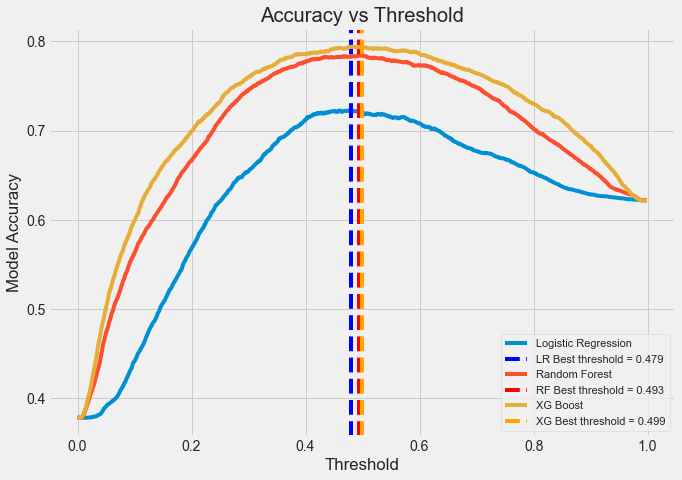

In [375]:
# We are concerned with accuracy of the model i.e. its ability to predict both the 0 and 1 labels correctly
# So we will calculate the accuracy score at different thresholds directly

fig, ax = plt.subplots(1,1, figsize=(10,7))

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

# for LR model
ac_score_lr = [accuracy_score(y_test.astype('int'), to_labels(lr_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_lr)
print(f"Logistic Regression Model\nBest Accuracy score of {ac_score_lr[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_lr, label='Logistic Regression')
plt.axvline(thresholds[idx], color='blue', linestyle="--", label = "LR Best threshold = "+str(np.round(thresholds[idx],4)))

# for random forest
thresholds = np.arange(0, 1, 0.001)
ac_score_rf = [accuracy_score(y_test.astype('int'), to_labels(rf_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_rf)
print(f"Random Forest Model\nBest Accuracy score of {ac_score_rf[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_rf, label='Random Forest')
plt.axvline(thresholds[idx], color='red', linestyle="--", label = "RF Best threshold = "+str(np.round(thresholds[idx],4)))

# for XG Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_xg = [accuracy_score(y_test.astype('int'), to_labels(xg_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_xg)
print(f"XG Boost Model\nBest Accuracy score of {ac_score_xg[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_xg, label='XG Boost')
plt.axvline(thresholds[idx], color='orange', linestyle="--", label = "XG Best threshold = "+str(np.round(thresholds[idx],4)))

plt.legend()
plt.xlabel('Threshold')
plt.xticks(fontsize=14)
plt.ylabel('Model Accuracy')
plt.yticks(fontsize=14)
plt.title('Accuracy vs Threshold')

plt.show()
fig.savefig("charts/thresholding.jpg")


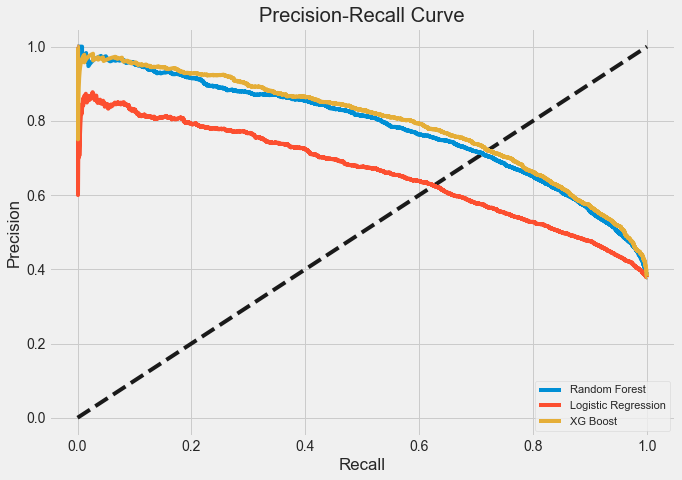

In [376]:
#Let's plot the precision-recall curves for all models
fig, ax = plt.subplots(1,1, figsize=(10,7))

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.astype('int'), rf_probs)
precision_xg, recall_xg, thresholds_xg = precision_recall_curve(y_test.astype('int'), xg_probs)
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test.astype('int'), lr_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.plot(recall_lr, precision_lr, label='Logistic Regression')
plt.plot(recall_xg, precision_xg, label='XG Boost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
fig.savefig("charts/precision_recall_curve.jpg")

### Model Evaluation

1. The best model (XG Boost) is able to classify 79.4% of the users correctly. It does a good job of predicting users that will not remain active with 87% correct classification, but predicts only 67% of the active users correctly. For both classes (active and inactive), the XG Boost model performs better than the second best model (Random Forest).

2. XG Boost also performed well on the AUC metric, with a good score of 0.8602, followed by Random Forest at 0.8503.



### Insights from Model building

The Top 5 features that were used by the best model (XG Boost) to make predictions, provide us some great insights on factors most important for retention:

* **City**: City of King's Landing was the most important feature, with City of Winterfell being no.5 We saw during EDA that 63% of users from City of King's Landing remained active after 6 months. Ultimate should focus and invest on growing their customer base in this city, as it would give them a loyal set of customers.


* **Ultimate black usage**: This was the second most important feature. Again we saw during EDA that 50% of Ultimate black users stay active. So Ultimate Inc. could provide some incentive to users for experiencing this service as it is likely to pay dividends by making customers more sticky.


* **Phone**: This was the third most important feature, with iPhone users twice more likely to remain active (45%) as compared to Android users(21%). While Ultimate cannot influence the phone used by a particular user, it might help to understand whether iPhone brand represents a certain demographic that is more predisposed to ride-hailing service e.g. iPhone users might be younger as compared to Android users. It would also help to understand if the Ultimate app for these two platforms offers any differential experience that might be causing this behavior.  


* **Avg. rating by driver**: The ratings given by drivers to users was the 4th most important parameter. We found that a larger % of users with a 4.6 to 4.8 rating given by drivers are likely to stay active. So Ultimate would do well to 'listen' to its driver partners!
 